
- For the sake of this program, CO2 emissions per second of computer usage will be assumed to be 0.0001g, this may be higher or lower than the actual value but will still be close to accurate
- For this reason, the program (for the sake of simplicity) will ask if you are giving an answer in seconds, minutes or hours
- Breaktime is determined based on the duration of computer usage

In [10]:
import json
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from datetime import datetime, timedelta

# Creating baseline values -----
BASE_RATE = 0.0001
MINIMUM = 300

In [11]:
def calc_co2_usage(seconds: float) -> dict:
    # Calculate estimated carbon footprint from seconds.
    total_co2 = seconds * BASE_RATE
    mins = seconds / 60
    hours = mins / 60

    return {
        "seconds": round(seconds, 2),
        "minutes": round(mins, 2),
        "hours": round(hours, 2),
        "co2_kg": round(total_co2, 6)
    }
calc_co2_usage(1000)

{'seconds': 1000, 'minutes': 16.67, 'hours': 0.28, 'co2_kg': 0.1}

In [12]:
def breaktime(seconds):
    # calculate the rough time when a break would be needed if hours are spent
    mins = seconds / 60
    hours = mins / 60

    if seconds >= MINIMUM:  
        contemp = datetime.now()
        if hours > 5:
            break_add = 2
            break_t = contemp + timedelta (hours=break_add)
            return break_t
            
            
        else:
            break_add = hours / 2
            if (hours / 2) < 1:
                new_mins = (hours / 2) * 60
                break_t = contemp + timedelta(minutes=new_mins)
                return break_t
            else:
                break_t = contemp + timedelta(hours=break_add)
                return break_t
    else:
        break_t = None
        return break_t

breaktime(8 * 60 * 60).strftime("%Y-%m-%d %H:%M:%S")


'2025-12-02 01:32:13'

In [13]:
# Tkinter initialisation ------
class ComputerCO2App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Computer Usage Monitor")
        self.geometry("480x420")
        self.resizable(False, False)
        self._create_widgets()

    def _create_widgets(self):
        padding = {'padx': 10, 'pady': 6}

        ttk.Label(
            self,
            text="Computer Carbon Estimator",
            font=("Arial", 16, "bold")
        ).pack(pady=(10, 4))

        ttk.Label(
            self,
            text="Estimate your carbon footprint from your screen time!",
            font=("Arial", 10)
        ).pack(pady=(0, 10))

        frame = ttk.Frame(self)
        frame.pack(fill="x", padx=20, pady=8)

        # Time entry
        ttk.Label(frame, text="Screen time:").grid(row=0, column=0, sticky="w")
        self.time_entry = ttk.Entry(frame, width=10)
        self.time_entry.grid(row=0, column=1, sticky="w")
        self.time_entry.insert(0, "60")

        # Unit selection
        ttk.Label(frame, text="Units:").grid(row=0, column=2, sticky="w", padx=(10, 0))
        self.unit_var = tk.StringVar(value="seconds")
        units = ["seconds", "minutes", "hours"]
        ttk.OptionMenu(frame, self.unit_var, units[0], *units).grid(row=0, column=3, sticky="w")

        # Buttons
        btn_frame = ttk.Frame(self)
        btn_frame.pack(fill="x", padx=20, pady=(8, 4))
        ttk.Button(btn_frame, text="Calculate", command=self.on_calculate).pack(side="left")
        ttk.Button(btn_frame, text="Save Report", command=self.on_save).pack(side="left", padx=(8, 0))
        ttk.Button(btn_frame, text="Tips", command=self.show_tips).pack(side="left", padx=(8, 0))

        # Result display
        result_frame = ttk.LabelFrame(self, text="Results")
        result_frame.pack(fill="both", expand=True, padx=20, pady=(8, 12))

        self.result_text = tk.Text(result_frame, height=8, wrap="word", state="disabled")
        self.result_text.pack(fill="both", expand=True, padx=8, pady=8)



        self.last_result = None

    # -----------------------------
    # EVENT HANDLERS
    # -----------------------------
    def on_calculate(self):
        try:
            time_val = float(self.time_entry.get())
            if time_val < 0:
                raise ValueError("Time cannot be negative.")

            unit = self.unit_var.get()
            # convert all to seconds
            if unit == "minutes":
                seconds = time_val * 60
            elif unit == "hours":
                seconds = time_val * 3600
            else:
                seconds = time_val

            result = calc_co2_usage(seconds)
            self.last_result = result
            suggest = breaktime(seconds)

            if suggest is not None:
                display = (
                    f"Usage Time: {result['hours']} hours "
                    f"({result['minutes']} mins, {result['seconds']} secs)\n"
                    f"Estimated CO2 Emissions: {result['co2_kg']} kg\n\n"
                    f"That’s approximately {result['co2_kg']*1000:.2f} grams of CO2.\n"
                    f"Tip: Turning off your PC when idle can save power and emissions! \n"
                    f"Break: Please take a break at {suggest}"
                )
            else:
                display = (
                    f"Usage Time: {result['hours']} hours "
                    f"({result['minutes']} mins, {result['seconds']} secs)\n"
                    f"Estimated CO2 Emissions: {result['co2_kg']} kg\n\n"
                    f"That’s approximately {result['co2_kg']*1000:.2f} grams of CO2.\n"
                    f"Tip: Turning off your PC when idle can save power and emissions! \n"
                )

            self._set_result(display)

        except ValueError:
            messagebox.showerror("Invalid Input", "Please enter a valid numeric value for time.")

    def _set_result(self, text):
        self.result_text.config(state="normal")
        self.result_text.delete("1.0", "end")
        self.result_text.insert("1.0", text)
        self.result_text.config(state="disabled")

    def on_save(self):
        if not self.last_result:
            messagebox.showinfo("No Data", "Please calculate a result first.")
            return
        path = filedialog.asksaveasfilename(
            defaultextension=".json",
            filetypes=[("JSON Files", "*.json")],
            title="Save Carbon Footprint Report"
        )
        if not path:
            return
        try:
            with open(path, "w", encoding="utf-8") as f:
                json.dump(self.last_result, f, indent=2)
            messagebox.showinfo("Saved", f"Report saved to {path}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save report:\n{e}")

    def show_tips(self):
        tips = [
            "- Tips to reduce your computer-based carbon footprint:",
            "- Switch off your computer when not in use.",
            "- Take regular breaks where you completely switch off your computer",
            "- Use energy-efficient hardware or laptops.",
            "- Slightly reduce screen brightness",
            "- Unplug your charger when the device is full. (if using a laptop)",
            "- Have at least one day a week where you completely step away from your computer",
            

        ]
        messagebox.showinfo("Eco Tips", "\n".join(tips))


In [14]:
app = ComputerCO2App()
app.mainloop()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("household_power_consumption.csv", sep=";", na_values="?")

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)

df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

df = df.dropna(subset=["Datetime", "Global_active_power"])

df


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00


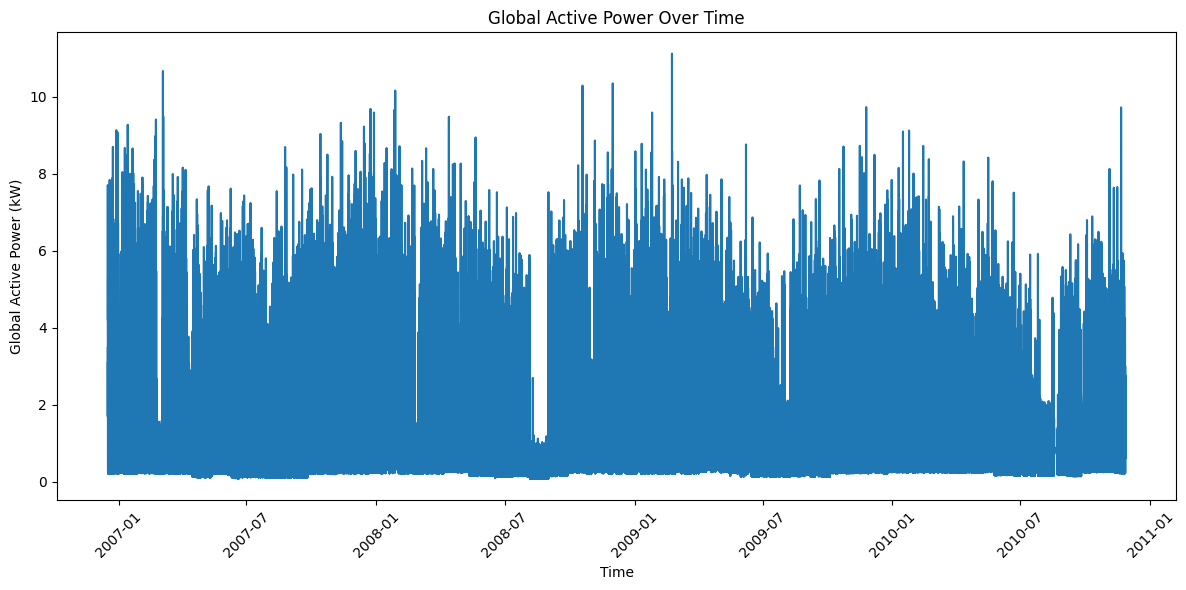

In [25]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(df["Datetime"], df["Global_active_power"])
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.title("Global Active Power Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()